In [ ]:
import tarfile
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import logging
from rdkit import Chem
import tempfile
import uuid

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# keep only the 12 targets you care about
PROP_LABELS = [
    "mu", "alpha",                  # dipole moment (D), polarizability (Å³)
    "homo", "lumo", "gap",          # orbital energies (Ha) and gap (Ha)
    "r2",                           # <R²> (a₀²)
    "zpve",                         # zero‑point vibrational energy (Ha)
    "U0", "U", "H", "G",            # energies / enthalpy / free energy (Ha)
    "Cv"                            # heat capacity (cal mol‑¹ K‑¹)
]

IGNORED = 3                         # rotA, rotB, rotC

def parse_qm9_xyz(xyz_path: str | Path) -> dict:
    """
    Read one QM9‑style .xyz file and return:
        {
            'index' : 3895,
            'smiles': 'O=C1C=CON=N1',
            'props' : {label: value, …}   # the 12 targets (rotA/B/C omitted)
        }
    """
    lines = Path(xyz_path).read_text().splitlines()

    # ── header ──────────────────────────────────────────────────────────────
    n_atoms = int(lines[0])                 # sanity‑check only
    header_parts = lines[1].split('\t')

    # “gdb 3895” → tag = 'gdb', idx = 3895
    tag, idx = header_parts[0].split()
    idx = int(idx)

    # Skip the first three values, then take the next 12
    start = 1 + IGNORED                    # 1 = first value column after “gdb idx”
    end   = start + len(PROP_LABELS)
    prop_values = list(map(float, header_parts[start:end]))
    props = dict(zip(PROP_LABELS, prop_values))

    # ── comment block ───────────────────────────────────────────────────────
    smiles = lines[-2].split('\t')[0]      # first token on the penultimate line

    return {"index": idx, "smiles": smiles, "props": props}


def process_tar_gz(tar_path: str | Path, output_csv: str | Path) -> None:
    """
    Process a .tar.gz file containing QM9 .xyz files and save the dataset to a CSV.

    Args:
        tar_path: Path to the .tar.gz file.
        output_csv: Path to save the output CSV file.
    """
    records = []
    temp_dir = Path(tempfile.gettempdir()) / f"qm9_processing_{uuid.uuid4()}"

    try:
        # Create temporary directory
        temp_dir.mkdir(parents=True, exist_ok=True)

        with tarfile.open(tar_path, "r:gz") as tar:
            xyz_files = [member for member in tar.getmembers() if member.name.endswith(".xyz")]
            logger.info(f"Found {len(xyz_files)} .xyz files in {tar_path}")

            for member in tqdm(xyz_files, desc="Processing .xyz files"):
                try:
                    f = tar.extractfile(member)
                    if f is None:
                        logger.warning(f"Could not extract {member.name}")
                        continue

                    # Use unique temporary file name
                    temp_xyz = temp_dir / f"{uuid.uuid4()}.xyz"
                    content = f.read().decode("utf-8")
                    temp_xyz.write_text(content)

                    result = parse_qm9_xyz(temp_xyz)
                    if result:
                        record = {"index": result["index"], "smiles": result["smiles"]}
                        record.update(result["props"])
                        records.append(record)
                    else:
                        logger.warning(f"Skipping {member.name}: Parsing failed")

                    # Clean up temporary file
                    temp_xyz.unlink()
                except Exception as e:
                    logger.error(f"Error processing {member.name}: {e}")
                    continue
    except Exception as e:
        logger.error(f"Error opening tar file {tar_path}: {e}")
        return
    finally:
        # Clean up temporary directory
        try:
            for temp_file in temp_dir.glob("*.xyz"):
                temp_file.unlink()
            temp_dir.rmdir()
        except Exception as e:
            logger.warning(f"Error cleaning up temporary directory {temp_dir}: {e}")

    if records:
        df = pd.DataFrame(records)
        columns = ["index", "smiles"] + PROP_LABELS
        df = df[columns]
        df = df.sort_values("index")
        df.to_csv(output_csv, index=False)
        logger.info(f"Saved dataset with {len(df)} records to {output_csv}")
    else:
        logger.warning("No valid records processed.")

if __name__ == "__main__":
    tar_path = "dataset.tar.gz"  # Your provided file
    output_csv = "qm9_dataset.csv"  # Output CSV file
    process_tar_gz(tar_path, output_csv)

2025-05-02 17:19:22,684 - INFO - Found 11001 .xyz files in dataset.tar.gz
Processing .xyz files: 100%|██████████| 11001/11001 [06:27<00:00, 28.36it/s]
2025-05-02 17:25:50,928 - INFO - Saved dataset with 11001 records to qm9_dataset.csv


In [ ]:
import pandas as pd

df = pd.read_csv("qm9_dataset.csv")
print(df.columns)        # → Index(['index', 'smiles', 'props'], dtype='object')
print(df.shape)          # → (11000, 3)   ← your exact row‑count may differ
print(df.head())         # → first 5 rows of the DataFrame

Index(['index', 'smiles', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve',
       'U0', 'U', 'H', 'G', 'Cv'],
      dtype='object')
(11001, 14)
   index        smiles      mu  alpha    homo    lumo     gap        r2  \
0   3895  O=C1C=CON=N1  3.3067  46.55 -0.2630 -0.0607  0.2023  965.3567   
1   3896  O=C1C=NOC=N1  2.4177  46.66 -0.2701 -0.0861  0.1840  567.5171   
2   3897  O=C1C=NON=C1  0.2386  48.24 -0.2681 -0.1008  0.1674  577.0287   
3   3898  O=C1C=NON=N1  1.5473  45.28 -0.2714 -0.1200  0.1514  556.6358   
4   3899  O=C1N=CON=N1  1.7309  41.79 -0.2961 -0.0570  0.2391  913.3757   

       zpve          U0           U           H           G      Cv  
0  0.049003 -375.430225 -375.421157 -375.420213 -375.469933  24.943  
1  0.055941 -375.359188 -375.354066 -375.353122 -375.388412  17.987  
2  0.054950 -375.307060 -375.301908 -375.300964 -375.336105  18.514  
3  0.041330 -391.337881 -391.332272 -391.331328 -391.367925  19.012  
4  0.038631 -391.518453 -391.509552 -391.508608 -391

In [20]:
import os
import numpy as np
from rdkit import RDConfig, Chem
fName=os.path.join(RDConfig.RDDataDir,'FunctionalGroups.txt')
from rdkit.Chem import FragmentCatalog
fparams = FragmentCatalog.FragCatParams(1,6,fName)
fparams.GetNumFuncGroups()
fcat=FragmentCatalog.FragCatalog(fparams)
fcgen=FragmentCatalog.FragCatGenerator()

# Preallocate the number of functional groups for each molecule
num_func_groups = np.zeros(len(df), dtype=int)
num_atoms = np.zeros(len(df), dtype=int)


smiles_column = df['smiles']
for i, smiles in enumerate(smiles_column):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Generate functional groups for the molecule
        num_func_groups[i] = fcgen.AddFragsFromMol(mol,fcat)
        num_atoms[i] = mol.GetNumAtoms()
        

    else:
        print(f"Invalid SMILES: {smiles}")
        continue

# Add num_func_groups and num_atoms as new columns to the DataFrame
df['num_func_groups'] = num_func_groups
df['num_atoms'] = num_atoms

In [21]:
print(num_func_groups[:10])  # Print the first 10 functional groups counts
print(num_atoms[:10])  # Print the first 10 atom counts
print(df.head())  # Display the first 5 rows with the new columns

[31 24 12 11 14  6 19 13 16 16]
[7 7 7 7 7 7 7 7 7 7]
   index        smiles      mu  alpha    homo    lumo     gap        r2  \
0   3895  O=C1C=CON=N1  3.3067  46.55 -0.2630 -0.0607  0.2023  965.3567   
1   3896  O=C1C=NOC=N1  2.4177  46.66 -0.2701 -0.0861  0.1840  567.5171   
2   3897  O=C1C=NON=C1  0.2386  48.24 -0.2681 -0.1008  0.1674  577.0287   
3   3898  O=C1C=NON=N1  1.5473  45.28 -0.2714 -0.1200  0.1514  556.6358   
4   3899  O=C1N=CON=N1  1.7309  41.79 -0.2961 -0.0570  0.2391  913.3757   

       zpve          U0           U           H           G      Cv  \
0  0.049003 -375.430225 -375.421157 -375.420213 -375.469933  24.943   
1  0.055941 -375.359188 -375.354066 -375.353122 -375.388412  17.987   
2  0.054950 -375.307060 -375.301908 -375.300964 -375.336105  18.514   
3  0.041330 -391.337881 -391.332272 -391.331328 -391.367925  19.012   
4  0.038631 -391.518453 -391.509552 -391.508608 -391.558096  23.419   

   num_func_groups  num_atoms  
0               31          7  
1   

In [ ]:
print(df.describe())  # Summary statistics for numerical columns

             index            mu         alpha          homo          lumo  \
count  11001.00000  11001.000000  11001.000000  11001.000000  11001.000000   
mean    9395.00000      2.667524     69.053140     -0.243653      0.012465   
std     3175.85949      1.520536      6.891029      0.023878      0.046326   
min     3895.00000      0.000000     36.250000     -0.369500     -0.175000   
25%     6645.00000      1.530600     64.580000     -0.257000     -0.022600   
50%     9395.00000      2.476500     68.770000     -0.245000      0.015700   
75%    12145.00000      3.626800     73.420000     -0.233600      0.048600   
max    14895.00000     18.691500    119.420000     -0.146000      0.101200   

                gap            r2          zpve            U0             U  \
count  11001.000000  11001.000000  11001.000000  11001.000000  11001.000000   
mean       0.256118   1061.182057      0.139683   -377.359704   -377.351436   
std        0.047151    232.643735      0.031935     30.09817

In [24]:
df.to_csv("dataset_isomer_atom.csv", index=False)

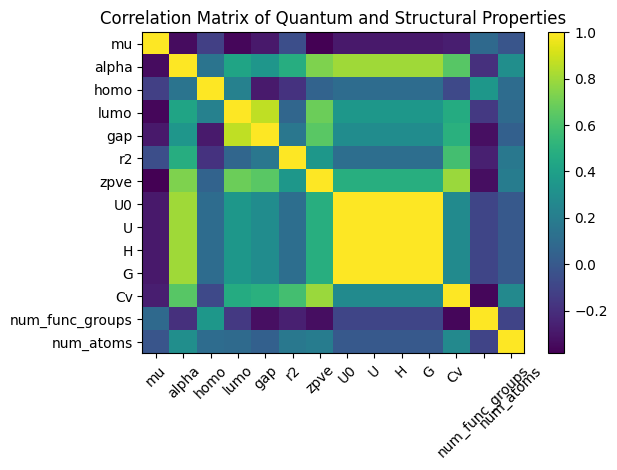

In [27]:
import matplotlib.pyplot as plt
# Extract column labels
properties = df.columns.tolist()
# Exclude 'index' and 'smiles' from the list of properties
properties.remove('index')
properties.remove('smiles')

corr = df[properties].corr()

plt.figure()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(properties)), properties, rotation=45)
plt.yticks(range(len(properties)), properties)
plt.title('Correlation Matrix of Quantum and Structural Properties')
plt.tight_layout()
plt.show()

